# Bayesian MLP for MNIST using preconditioned SGLD

We use the [Jax Bayes](https://github.com/jamesvuc/jax-bayes) library 
by  James Vuckovic 
to fit an MLP to MNIST using SGD, and SGLD (with RMS preconditioning).
Code is based on:



1.   https://github.com/jamesvuc/jax-bayes/blob/master/examples/deep/mnist/mnist.ipynb
2.   https://github.com/jamesvuc/jax-bayes/blob/master/examples/deep/mnist/mnist_mcmc.ipynb


# Setup

In [1]:
%%capture

!pip install -qq git+https://github.com/jamesvuc/jax-bayes
!pip install -qq SGMCMCJax
!pip install -qq distrax

In [2]:
import jax.numpy as jnp
from jax.experimental import optimizers
import jax

try:
    import jax_bayes
except ModuleNotFoundError:
    %pip install -qq jax_bayes
    import jax_bayes

try:
    import sys, os, math, time
except ModuleNotFoundError:
    %pip install -qq sys,
    import sys, os, math, time
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds

In [3]:
try:
    import sgmcmcjax
except ModuleNotFoundError:
    %pip install -qq sgmcmcjax
    import sgmcmcjax
from jax import jit, vmap
from jax.random import split, PRNGKey

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    from tqdm.auto import tqdm
except ModuleNotFoundError:
    %pip install -qq tqdm
    from tqdm.auto import tqdm
try:
    import tensorflow_probability.substrates.jax.distributions as tfd
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability.substrates.jax.distributions as tfd

# Data

In [4]:
def load_dataset(split, is_training, batch_size):
    if batch_size == -1:
        ds = tfds.load("mnist:3.*.*", split=split, batch_size=-1)
    else:
        ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training and batch_size > 0:
        ds = ds.shuffle(10 * batch_size, seed=0)
    if batch_size > 0:
        ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds)) if batch_size > 0 else tfds.as_numpy(ds)

In [5]:
# load the data into memory and create batch iterators
train_batches = load_dataset("train", is_training=True, batch_size=1_000)
val_batches = load_dataset("train", is_training=False, batch_size=10_000)
test_batches = load_dataset("test", is_training=False, batch_size=10_000)

The Bayesian NN is taken from [SGMCMCJAX](https://github.com/jeremiecoullon/SGMCMCJax/blob/7da21c0c79606e908c2292533c176349d9349cd0/docs/nbs/models/bayesian_NN/NN_model.py). However, there are couple of changes made. These can be listed as follows:

1. The random_layer function initialises weights from truncated_normal rather than normal distribution.

2. The random_layer function initialises weights with zeros rather than sampling from normal distribution.

3. Activation function can be determined instead of using only softmax function. 

In [6]:
# ==========
# Functions to initialise parameters
# initialise params: list of tuples (W, b) for each layer
def random_layer(key, m, n, scale=1e-2):
    key, subkey = jax.random.split(key)
    return (scale * jax.random.truncated_normal(key, -2, 2, (n, m)), jnp.zeros((n,)))


def init_network(key, sizes):
    keys = jax.random.split(key, len(sizes))
    return [random_layer(k, m, n) for k, m, n in zip(keys, sizes[:-1], sizes[1:])]


# ===========
# predict and accuracy functions
@partial(jit, static_argnames=("activation_fn"))
def predict(params, x, activation_fn):
    # per-example predictions
    activations = x
    for w, b in params[:-1]:
        outputs = activations @ w.T + b
        activations = activation_fn(outputs)

    final_w, final_b = params[-1]
    logits = activations @ final_w.T + final_b
    return logits


# =================
# Log-posterior
@partial(jit, static_argnames=("activation_fn"))
def loglikelihood(params, X, y, activation_fn):
    return jnp.sum(y * jax.nn.log_softmax(predict(params, X, activation_fn)))


def logprior(params):
    logP = 0.0
    dist = distrax.Normal(0, 1)
    for w, b in params:
        logP += jnp.sum(dist.log_prob(w))
        logP += jnp.sum(dist.log_prob(b))
    return logP


# Accuracy for a single sample
batch_predict = vmap(predict, in_axes=(None, 0, None))


@partial(jit, static_argnames=("activation_fn"))
def accuracy(params, batch, activation_fn):
    X, target_class = batch["image"].reshape((-1, D)), batch["label"]
    predicted_class = jnp.argmax(batch_predict(params, X, activation_fn), axis=1)
    return jnp.mean(predicted_class == target_class)

In [7]:
batch = next(train_batches)
nclasses = 10
x = batch["image"]
D = np.prod(x.shape[1:])  # 784
sizes = [D, 300, 100, nclasses]

# Model

# SGD

In [8]:
def loss(params, batch, activation_fn):
    logits = predict(params, batch["image"].reshape((-1, D)), activation_fn)
    labels = jax.nn.one_hot(batch["label"], nclasses)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

    softmax_crossent = -jnp.mean(labels * jax.nn.log_softmax(logits))

    return softmax_crossent + reg * l2_loss


@partial(jit, static_argnames=("activation_fn"))
def train_step(i, opt_state, batch, activation_fn):
    params = opt_get_params(opt_state)
    dx = jax.grad(loss)(params, batch, activation_fn)
    opt_state = opt_update(i, dx, opt_state)
    return opt_state

In [9]:
reg = 1e-3
lr = 1e-3
opt_init, opt_update, opt_get_params = optimizers.rmsprop(lr)
initial_params = init_network(PRNGKey(0), sizes)
opt_state = opt_init(initial_params)
activation_fn = jax.nn.relu

In [10]:
%%time
accuracy_list_train, accuracy_list_test = [], []
nsteps = 2000

print_every = 100

for step in tqdm(range(nsteps + 1)):
    opt_state = train_step(step, opt_state, next(train_batches), activation_fn)
    params_sgd = opt_get_params(opt_state)
    if step % print_every == 0:
        # Periodically evaluate classification accuracy on train & test sets.
        train_accuracy = accuracy(params_sgd, next(val_batches), activation_fn)
        test_accuracy = accuracy(params_sgd, next(test_batches), activation_fn)
        accuracy_list_train.append(train_accuracy)
        accuracy_list_test.append(test_accuracy)

  0%|          | 0/2001 [00:00<?, ?it/s]

CPU times: user 21.4 s, sys: 6.04 s, total: 27.4 s
Wall time: 14.2 s


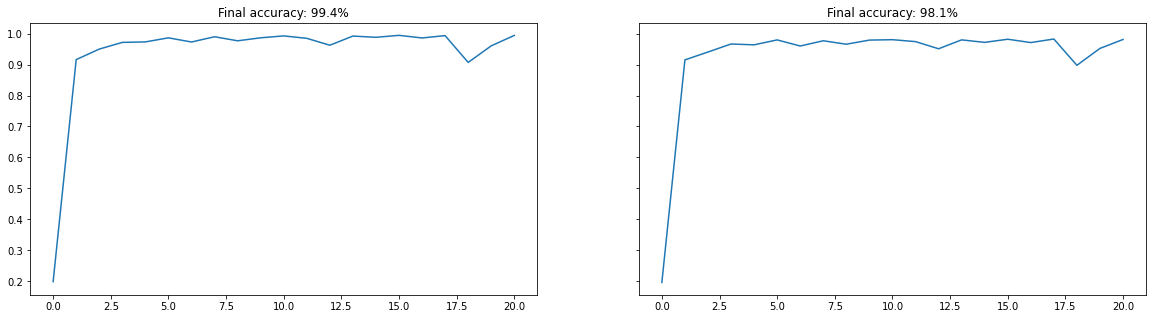

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 5))

for ls, ax in zip([accuracy_list_train, accuracy_list_test], axes.flatten()):
    ax.plot(ls[:])
    ax.set_title(f"Final accuracy: {100*ls[-1]:.1f}%")

# SGLD

In [12]:
try:
    from sgmcmcjax.kernels import build_sgld_kernel
except ModuleNotFoundError:
    %pip install -qq sgmcmcjax
    from sgmcmcjax.kernels import build_sgld_kernel
from sgmcmcjax.util import progress_bar_scan

In [13]:
lr = 5e-5
activation_fn = jax.nn.softmax

data = load_dataset("train", is_training=True, batch_size=-1)
data = (jnp.array(data["image"].reshape((-1, D)) / 255.0), jax.nn.one_hot(jnp.array(data["label"]), nclasses))
batch_size = int(0.01 * len(data[0]))

init_fn, my_kernel, get_params = build_sgld_kernel(
    lr, partial(loglikelihood, activation_fn=activation_fn), logprior, data, batch_size
)
my_kernel = jit(my_kernel)

# define the inital state
key = jax.random.PRNGKey(10)
key, subkey = jax.random.split(key, 2)
params_IC = init_network(subkey, sizes)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [14]:
%%time

# iterate the the Markov chain
nsteps = 2000
Nsamples = 10


@partial(jit, static_argnums=(1,))
def sampler(key, Nsamples, params):
    def body(carry, i):
        key, state = carry
        key, subkey = jax.random.split(key)
        state = my_kernel(i, subkey, state)
        return (key, state), get_params(state)

    key, subkey = jax.random.split(key)
    state = init_fn(subkey, params)
    (_, state), samples = jax.lax.scan(body, (key, state), jnp.arange(Nsamples))
    return samples, state


accuracy_list_test, accuracy_list_val = [], []

params = params_IC
for step in tqdm(range(nsteps)):
    key, sample_key = jax.random.split(key, 2)
    samples, state = sampler(sample_key, Nsamples, params)
    params = get_params(state)
    if step % print_every == 0:
        test_acc, val_acc = accuracy(params, next(test_batches), activation_fn), accuracy(
            params, next(val_batches), activation_fn
        )
        accuracy_list_test.append(test_acc)
        accuracy_list_val.append(val_acc)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


CPU times: user 17.6 s, sys: 812 ms, total: 18.4 s
Wall time: 16.5 s


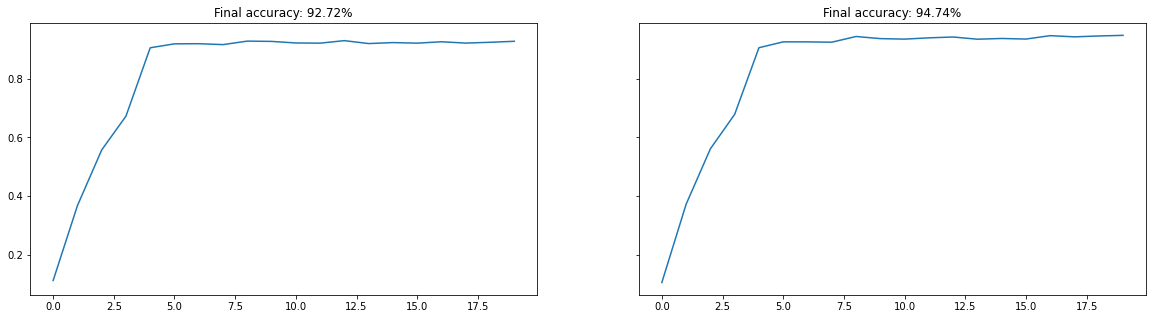

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 5))

for ls, ax in zip([accuracy_list_test, accuracy_list_val], axes.flatten()):
    ax.plot(ls[:])
    ax.set_title(f"Final accuracy: {100*ls[-1]:.2f}%")

# Uncertainty analysis

We select the predictions above a confidence threshold, and compute the predictive accuracy on that subset. As we increase the threshold, the accuracy should increase, but fewer examples will be selected.

The following two functions are taken from [JaxBayes](https://github.com/jamesvuc/jax-bayes/blob/master/jax_bayes/utils.py)

In [17]:
def certainty_acc(pp, targets, cert_threshold=0.5):
    """Calculates the accuracy-at-certainty from the predictive probabilites pp
    on the targets.
    Args:
        pp: (batch_size, n_classes) array of probabilities
        targets: (batch_size, n_calsses) array of label class indices
        cert_threhsold: (float) minimum probability for making a prediction
    Returns:
        accuracy at certainty, indicies of those prediction instances for which
        the model is certain.
    """
    preds = jnp.argmax(pp, axis=1)
    pred_probs = jnp.max(pp, axis=1)

    certain_idxs = pred_probs >= cert_threshold
    acc_at_certainty = jnp.mean(targets[certain_idxs] == preds[certain_idxs])

    return acc_at_certainty, certain_idxs


@jit
@vmap
def entropy(p):
    """computes discrete Shannon entropy.
    p: (n_classes,) array of probabilities corresponding to each class
    """
    p += 1e-12  # tolerance to avoid nans while ensuring 0log(0) = 0
    return -jnp.sum(p * jnp.log(p))

In [18]:
test_batch = next(test_batches)

In [19]:
def plot_acc_vs_confidence(predict_fn, test_batch):
    # plot how accuracy changes as we increase the required level of certainty
    preds = predict_fn(test_batch)  # (batch_size, n_classes) array of probabilities
    acc, mask = certainty_acc(preds, test_batch["label"], cert_threshold=0)
    thresholds = [0.1 * i for i in range(11)]
    cert_accs, pct_certs = [], []
    for t in thresholds:
        cert_acc, cert_mask = certainty_acc(preds, test_batch["label"], cert_threshold=t)
        cert_accs.append(cert_acc)
        pct_certs.append(cert_mask.mean())

    fig, ax = plt.subplots(1)
    line1 = ax.plot(thresholds, cert_accs, label="accuracy at certainty", marker="x")
    line2 = ax.axhline(y=acc, label="regular accuracy", color="black")
    ax.set_ylabel("accuracy")
    ax.set_xlabel("certainty threshold")

    axb = ax.twinx()
    line3 = axb.plot(thresholds, pct_certs, label="pct of certain preds", color="green", marker="x")
    axb.set_ylabel("pct certain")

    lines = line1 + [line2] + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=6)

    return fig, ax

## SGD

For the plugin estimate, the model is very confident on nearly all of the points.

In [20]:
# plugin approximation to  posterior predictive
@partial(jit, static_argnames=("activation_fn"))
def posterior_predictive_plugin(params, X, activation_fn):
    logit_pp = predict(params, X, activation_fn)
    return jax.nn.softmax(logit_pp, axis=-1)

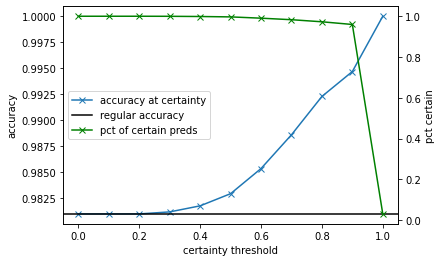

In [21]:
def pred_fn_sgd(batch):
    X = batch["image"].reshape((-1, D))
    return posterior_predictive_plugin(params_sgd, X, jax.nn.relu)


fig, ax = plot_acc_vs_confidence(pred_fn_sgd, test_batch)
plt.savefig("acc-vs-conf-sgd.pdf")
plt.show()

## SGLD

In [22]:
def posterior_predictive_bayes(params_sampled, batch, activation_fn):
    """computes the posterior_predictive P(class = c | inputs, params) using a histogram"""

    X = batch["image"].reshape((-1, D))
    y = batch["label"]

    pred_fn = lambda p: predict(p, X, activation_fn)
    pred_fn = jax.vmap(pred_fn)

    logit_samples = pred_fn(params_sampled)  # n_samples x batch_size x n_classes
    pred_samples = jnp.argmax(logit_samples, axis=-1)  # n_samples x batch_size

    n_classes = logit_samples.shape[-1]
    batch_size = logit_samples.shape[1]
    probs = np.zeros((batch_size, n_classes))
    for c in range(n_classes):
        idxs = pred_samples == c
        probs[:, c] = idxs.sum(axis=0)

    return probs / probs.sum(axis=1, keepdims=True)

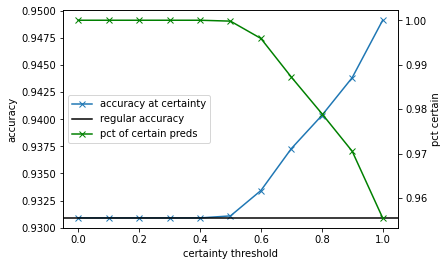

In [23]:
def pred_fn_sgld(batch):
    return posterior_predictive_bayes(samples, batch, jax.nn.softmax)


fig, ax = plot_acc_vs_confidence(pred_fn_sgld, test_batch)
plt.savefig("acc-vs-conf-sgld.pdf")
plt.show()

# Distribution shift

We now examine the behavior of the models on the Fashion MNIST dataset.
We expect the predictions to be much less confident, since the inputs are now 'out of distribution'. We will see that this is true for the Bayesian approach, but not for the plugin approximation. 

In [24]:
fashion_ds = tfds.load("fashion_mnist:3.*.*", split="test").cache().repeat()
fashion_test_batches = tfds.as_numpy(fashion_ds.batch(10_000))
fashion_test_batches = iter(fashion_test_batches)

fashion_batch = next(fashion_test_batches)

## SGD


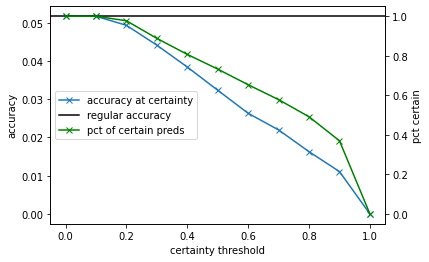

In [25]:
fig, ax = plot_acc_vs_confidence(pred_fn_sgd, fashion_batch)
plt.savefig("acc-vs-conf-sgd-fashion.pdf")
plt.show()

## SGLD



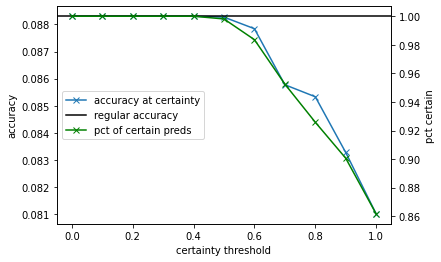

In [26]:
fig, ax = plot_acc_vs_confidence(pred_fn_sgld, fashion_batch)
plt.savefig("acc-vs-conf-sgld-fashion.pdf")
plt.show()